In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install selfies

In [ ]:

pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 52.4 MB/s eta 0:00:00


In [ ]:
# === IMPORT ===
# PyTorch per deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

 delle molecole
import selfies as sf

# Pandas e altri strumenti di base
import pandas as pd
from collections import Counter

🔴**Pre-processing del dataset**

 (Eseguito una tantum)

In [ ]:
'''
# Percorso del file disponibile
file_path = '/content/drive/MyDrive/Colab Notebooks/D3_226k_docking_results.csv'

# Conversione dei docking score da stringhe a float
df = pd.read_csv(file_path, delimiter=';')
df['Docking_scores'] = df['Docking_scores'].str.strip().str.replace(',', '.', regex=False).astype(float)

# Normalizzazione dei docking scores (se utile per stabilizzare la regressione): i valori avranno media 0 e varianza 1, più facili da modellare

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['Docking_scores_scaled'] = scaler.fit_transform(df[['Docking_scores']])


#Pulizia in sicurezza degli spazi da tutte le SMILES con:
df['SMILES'] = df['SMILES'].str.strip()

# Visualizzazione delle prime righe
df[['SMILES', 'Docking_scores']].head()
'''

🔴**Osservazione**

I duplicati falsano le metriche e riducono la capacità predittiva vera. Pertanto verranno rimossi

In [ ]:
'''
# Conta i duplicati basati solo su SMILES
dup_smiles = df[df.duplicated(subset=["SMILES"], keep=False)]
print(f" Molecole duplicate (solo SMILES): {len(dup_smiles)}")

# Conta i duplicati basati sia su SMILES che docking score
dup_exact = df[df.duplicated(subset=["SMILES", "Docking_scores"], keep=False)]
print(f" Righe duplicate complete (SMILES + score): {len(dup_exact)}")

# (Opzionale) Mostra i primi 5 duplicati completi
if not dup_exact.empty:
    print("\nEsempi di duplicati:")
    display(dup_exact.head())
'''

In [ ]:
'''
#Blocco esemplificativo per rintracciare gli SMILES identici (=formattati in maniera identica)

target_smiles = "O=C(OCC1=CC=CC=C1)N1CC(C(=O)N2CCCC23CCNC3)C1"

# Trova tutte le righe identiche
matching_rows = df[df["SMILES"] == target_smiles]

# Mostra tutte le occorrenze
print(f"Trovate {len(matching_rows)} occorrenze del composto:")
display(matching_rows)
'''

In [ ]:
'''
# tengo una sola istanza per ogni combinazione (SMILES + score):
df = df.drop_duplicates(subset=["SMILES", "Docking_scores"]).reset_index(drop=True)
print(f"🟢 Nuovo numero di molecole nel dataset: {len(df)}")
'''

✅ Nuovo numero di molecole nel dataset: 202774


##**La codifica SELFIES**

*Self-referencing Embedded Strings)* è un linguaggio alternativo a SMILES

* Ogni token rappresenta un atomo o costrutto chimico valido

* Tutte le stringhe SELFIES sono valide chimicamente

###**Differenze chiave : SMILES vs SELFIES**

*Aspetto:*SMILES / SELFIES

*Formato:* Testo "libero", molto compatto / Token strutturati tra parentesi

*Validità chimica:* Non garantita /                   100% validi chimicamente

*Tokenizzazione:* Ambigua (es. Cl vs C + l) / Esplicita (ogni token è un'entità completa)

*Presenza ramificazioni e anelli:* Gestiti con numeri e parentesi/  Esplicitate con token tipo [Branch1_1], [Ring1]

*Robustezza stringhe:* No,le stringhe generate casualmente sono spesso invalide/  Sì: ogni stringa SELFIES è decodificabile in una molecola valida

###**Questi argomenti fanno preferire la codifica Selfies**

In [ ]:
"""
# === TOKENIZZAZIONE SELFIES ===
# Converti SMILES → SELFIES
df['SELFIES'] = df['SMILES'].apply(sf.encoder)

# Tokenizza SELFIES in liste di token espliciti
df['SELFIES_tokens'] = df['SELFIES'].apply(sf.split_selfies)
"""

**DATA AUGMENTATION (tecniche per arricchire il dataset a disposizione)**

Sfruttando la libreria rdkit riproduco casualmente smiles equivalenti, ovvero smiles che rappresentano la stessa molecola - cosa ammissibile con SMILES, tanto che si parla, tra le altre di una forma canonica.


Così facendo:

*   La stringa SMILES cambia, ma la molecola no.
*   Il SELFIES generato cambia, ma è semanticamente equivalente.
*   Il docking score associato rimane valido, perché si tratta della stessa molecola (stessa struttura 3D usata per calcolare lo score).

In [ ]:
'''
from rdkit import Chem
from rdkit.Chem import AllChem
import selfies

#Esempio di procedimento per data_augmentation
# Molecola di partenza (es. fluoxetina)
original_smiles = 'CNCCC(O)COc1ccc(C(F)(F)F)cc1'
mol = Chem.MolFromSmiles(original_smiles)

# Lista per salvare SELFIES equivalenti
selfies_variants = []

# Genera 3 rappresentazioni SMILES random (della stessa molecola)
for i in range(3):
    # SMILES random valido (come struttura)
    smiles_random = Chem.MolToSmiles(mol, doRandom=True)
    # Converto in SELFIES
    selfie_str = selfies.encoder(smiles_random)
    selfie_tokens = list(selfies.split_selfies(selfie_str))

    selfies_variants.append({
        'smiles': smiles_random,
        'selfies_str': selfie_str,
        'selfies_tokens': selfie_tokens
    })

# Stampa le varianti generate
for i, variant in enumerate(selfies_variants):
    print(f"\n### Variante {i+1}")
    print("SMILES:        ", variant['smiles'])
    print("SELFIES:       ", variant['selfies_str'])
    print("SELFIES tokens:", variant['selfies_tokens'])


### Variante 1
SMILES:         C(C(O)CCNC)Oc1ccc(C(F)(F)F)cc1
SELFIES:        [C][Branch1][=Branch2][C][Branch1][C][O][C][C][N][C][O][C][=C][C][=C][Branch1][=Branch2][C][Branch1][C][F][Branch1][C][F][F][C][=C][Ring1][#Branch2]
SELFIES tokens: ['[C]', '[Branch1]', '[=Branch2]', '[C]', '[Branch1]', '[C]', '[O]', '[C]', '[C]', '[N]', '[C]', '[O]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[=Branch2]', '[C]', '[Branch1]', '[C]', '[F]', '[Branch1]', '[C]', '[F]', '[F]', '[C]', '[=C]', '[Ring1]', '[#Branch2]']

### Variante 2
SMILES:         FC(c1ccc(OCC(CCNC)O)cc1)(F)F
SELFIES:        [F][C][Branch2][Ring1][Branch1][C][=C][C][=C][Branch1][O][O][C][C][Branch1][Branch1][C][C][N][C][O][C][=C][Ring1][=C][Branch1][C][F][F]
SELFIES tokens: ['[F]', '[C]', '[Branch2]', '[Ring1]', '[Branch1]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[O]', '[O]', '[C]', '[C]', '[Branch1]', '[Branch1]', '[C]', '[C]', '[N]', '[C]', '[O]', '[C]', '[=C]', '[Ring1]', '[=C]', '[Branch1]', '[C]', '[F]', '[F]']

### V

In [ ]:
'''
from rdkit import Chem
import selfies
import pandas as pd

# Lista per contenere tutte le entry: originali + augmentate
augmented_data = []

# Itera sul dataset originale
for _, row in df.iterrows():
    smiles = row['SMILES']
    score = row['Docking_scores']  # o Docking_scores_scaled se preferisci

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        continue  # salta molecole non valide

    # Canonical SELFIES
    canonical_selfie = selfies.encoder(smiles)
    canonical_tokens = list(selfies.split_selfies(canonical_selfie))
    augmented_data.append((canonical_tokens, score))

    # Genera 2 versioni SELFIES random equivalenti
    for _ in range(2):
        random_smiles = Chem.MolToSmiles(mol, doRandom=True)
        random_selfie = selfies.encoder(random_smiles)
        random_tokens = list(selfies.split_selfies(random_selfie))
        augmented_data.append((random_tokens, score))

In [ ]:
'''
#CODICE PER SALVARE I DATI PREPROCESSATI
import pandas as pd

# Converte augmented_data in un DataFrame
aug_df = pd.DataFrame(augmented_data, columns=["selfies_tokens", "docking_score"])

# Opzionale: converte la lista di token in stringa per salvataggio CSV
aug_df["selfies_str"] = aug_df["selfies_tokens"].apply(lambda tokens: " ".join(tokens))

# Salva in CSV
aug_df[["selfies_str", "docking_score"]].to_csv("/content/drive/MyDrive/Colab Notebooks/augmented_selfies_dataset.csv", index=False)

print(" 🟢Dataset augmentato salvato in 'augmented_selfies_dataset.csv'")
"""

🔎 Da questo blocco riprende l'esecuzione

In [ ]:
#CODICE DA ESEGUIRE PER RECUPERARE I DATI PREPROCESSATI

import pandas as pd
df_aug = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/augmented_selfies_dataset.csv")

# Tokenizza le stringhe SELFIES separandole in lista di simboli
df_aug["selfies_tokens"] = df_aug["selfies_str"].apply(lambda s: s.split(" "))

# Rinomina il DataFrame per compatibilità col codice già scritto
augmented_data = df_aug

In [ ]:
#CONTROLLO PRESENZA DEI DATI
for i, row in augmented_data[:5].iterrows():
    print(f"Entry {i}:", row, "| Tipo:", type(row["selfies_str"]))

Entry 0: selfies_str       [C] [O] [C] [=Branch1] [C] [=O] [C@@H1] [C] [C...
docking_score                                              -6.19542
selfies_tokens    [[C], [O], [C], [=Branch1], [C], [=O], [C@@H1]...
Name: 0, dtype: object | Tipo: <class 'str'>
Entry 1: selfies_str       [C] [=Branch1] [C] [=O] [Branch1] [Ring1] [O] ...
docking_score                                              -6.19542
selfies_tokens    [[C], [=Branch1], [C], [=O], [Branch1], [Ring1...
Name: 1, dtype: object | Tipo: <class 'str'>
Entry 2: selfies_str       [O] [Branch1] [C] [C] [C] [=C] [C] [Branch1] [...
docking_score                                              -6.19542
selfies_tokens    [[O], [Branch1], [C], [C], [C], [=C], [C], [Br...
Name: 2, dtype: object | Tipo: <class 'str'>
Entry 3: selfies_str       [N] [C] [Branch2] [Ring1] [O] [C] [=Branch1] [...
docking_score                                              -7.97568
selfies_tokens    [[N], [C], [Branch2], [Ring1], [O], [C], [=Bra...
Name: 3, dtyp

🔵 **Costruzione del vocabolario e encoding numerico**

In [ ]:
from collections import Counter

# Accesso alla colonna 'selfies_tokens' e iterazione sui suoi valori
all_tokens = [tok for tokens in augmented_data["selfies_tokens"] for tok in tokens]
token_counter = Counter(all_tokens)

# Costruzione vocabolario SELFIES
selfies_vocab = {tok: idx + 1 for idx, tok in enumerate(sorted(token_counter))}
selfies_vocab['<PAD>'] = 0
inv_selfies_vocab = {idx: tok for tok, idx in selfies_vocab.items()}

# Codifica numerica
def encode_selfies(tokens, vocab):
    return [vocab[tok] for tok in tokens]

#ottengo le sequenze encoded e la lista degli scores dalle colonne 'selfies_tokens' e'docking_score'
encoded_sequences = [encode_selfies(tokens, selfies_vocab) for tokens in augmented_data["selfies_tokens"]]
docking_scores = augmented_data["docking_score"].tolist() # Convert docking scores to a list

🔵**SPLITTING CASUALE del DATASET**

Partendo dalle di datafrmes Panda :

* df['SELFIES_encoded'] → lista di sequenze numeriche

* df['Docking_scores'] (o Docking_scores_scaled) → target da predire

Opero una tripartizione dei dati secondo le percentuali:

1.  80% training

2.  10% validation

3.  10% test

In [ ]:
from sklearn.model_selection import train_test_split

# Estrazione delle liste
X = encoded_sequences
y = docking_scores # o Docking_scores_scaled y = df['Docking_scores_scaled'].tolist()


# Primo split: train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Secondo split: val vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {len(X_train)}  | Val: {len(X_val)}  | Test: {len(X_test)}")


Train: 486657  | Val: 60832  | Test: 60833


🔵**Preparazione del Dataset e del DataLoader PyTorch con padding dinamico.**

In [ ]:
# === 3 DATASET E DATALOADER CON PADDING ===
from torch.utils.data import Dataset, DataLoader
import torch

# === 1. Classe PyTorch Dataset ===
class DockingDataset(Dataset):
    def __init__(self, selfies_encoded, docking_scores):
        self.selfies_encoded = selfies_encoded
        self.docking_scores = docking_scores

    def __len__(self):
        return len(self.selfies_encoded)

    def __getitem__(self, idx):
        return self.selfies_encoded[idx], self.docking_scores[idx]

# === 2. Funzione per padding dinamico ===
def collate_fn(batch):
    """
    Prepara un batch:
    - operando il padding  delle sequenze alla stessa lunghezza
    - restituendo anche le lunghezze originali
    """
    sequences, scores = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    max_len = max(lengths)

    # Applica padding con 0 (indice <PAD>)
    padded_sequences = [seq + [0] * (max_len - len(seq)) for seq in sequences]

    return (
        torch.tensor(padded_sequences, dtype=torch.long),
        torch.tensor(scores, dtype=torch.float32),
        lengths
    )

# === 3. Creazione dei dataset ===
train_dataset = DockingDataset(X_train, y_train)
val_dataset   = DockingDataset(X_val, y_val)
test_dataset  = DockingDataset(X_test, y_test)

# === 4. Creazione dei DataLoader ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, collate_fn=collate_fn)



In [ ]:
# Ottieni un batch dal train_loader (per verifica)
sample_batch = next(iter(train_loader))

sequences, scores, lengths = sample_batch

print("Shape delle sequenze padded:", sequences.shape)
print("Primi 5 scores:", scores[:5])
print("Prime 5 lunghezze:", lengths[:5])

Shape delle sequenze padded: torch.Size([32, 53])
Primi 5 scores: tensor([-8.4788, -6.8734, -7.5062, -6.4379, -4.1521])
Prime 5 lunghezze: [44, 31, 38, 35, 36]


🔵**Definizione della rete neurale RNN.**

L'obiettivo è costruire un modello in PyTorch che:

* prenda in input le sequenze SMILES tokenizzate,

* le elabori con un Embedding Layer + LSTM,

* produca in output una stima del docking score (regressione).

├──►  Input: SMILES tokenizzati (con padding)

│

├──► Embedding Layer (trasforma token in vettori densi)

│

├──► LSTM (modella la sequenza chimica)

│

├──► Ultimo stato nascosto (embedding molecolare)

│

└──► Fully Connected Layer → Output: docking score




In [ ]:
#CLASSE DockingRNN

class DockingRNN(nn.Module):
    #metodo costruttore
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(DockingRNN, self).__init__()
        #layer di embedding che trasforma gli indici dei token in vettori densi di dimensione embedding_dim con token <PAD> ignorato
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        # LSTM riceve una sequenza di embedding ([batch, seq_len, embedding_dim])
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional = True,
            batch_first=True, #i batch sono nella forma [batch, seq, feature]
            dropout=dropout if num_layers > 1 else 0.0,  # dropout solo se >1 layer
        )

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim * 2, 1)# <==== Cambiato output layer

    #metodo forward che definisce la propagazione in avanti del modello
    #x: batch di sequenze codificate in indici SELFIES
    #lengths: lunghezze originali delle sequenze prima del padding (serve per pack_padded_sequence)
    def forward(self, x, lengths):
        #trasforma le sequenze in embedding [batch, seq_len, embedding_dim]
        embedded = self.embedding(x)
        #Comprime le sequenze per ignorare il padding durante il passaggio nell’LSTM (efficienza + correttezza).
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        #passa il batch attraverso l`LSTM e restituisce hidden, il tensore contenente l’output dell’ultimo timestep per ogni layer
        packed_ou, (hidden, _) = self.lstm(packed)


        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        # prendiamo le ultime hidden state in entrambe le direzioni
        forward_h = hidden[-2]   # ultimo layer forward
        backward_h = hidden[-1]  # ultimo layer backward
        final_h = torch.cat((forward_h, backward_h), dim=1)

        output = self.fc(final_h)
        return output.squeeze(1) #.squeeze(1) rimuove la dimensione [batch, 1] → [batch], semplificando il confronto con i target.


🔵**Istanziazione del modello secondo gli iperparametri e avvio addestramento**

Per monitorare l'andamento del  modello durante l'addestramento vengono salvati i valori di loss e altre metriche per ogni epoca.
Questo  permetterà di creare grafici che visualizzano l'evoluzione delle prestazioni del modello nel tempo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# === Parametri modello ===
vocab_size = len(selfies_vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout = 0.4
num_epochs = 30
patience = 3
save_path = "best_model.pt"

# === Istanziamo il modello  ===
model = DockingRNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Definizione della funzione di Loss e ottimizzatore con regolarizzazione L2 (weight decay)===
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# === Liste per salvare le perdite ===
train_losses = []
val_losses = []

# === Early stopping tracker ===
best_val_loss = float('inf')
counter = 0

# Liste per salvare le metriche
train_mae, val_mae = [], []
train_rmse, val_rmse = [], []
train_r2, val_r2 = [], []

# === Ciclo di addestramento ===
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    train_predictions, train_targets = [], []

    for batch in train_loader:
        sequences, scores, lengths = batch
        sequences = sequences.to(device)
        scores = scores.to(device)

        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        train_predictions.extend(outputs.cpu().detach().numpy())
        train_targets.extend(scores.cpu().detach().numpy())



# Calcolo delle metriche sul set di training
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_mae.append(mean_absolute_error(train_targets, train_predictions))
    train_rmse.append(np.sqrt(mean_squared_error(train_targets, train_predictions)))
    train_r2.append(r2_score(train_targets, train_predictions))


 # === Validazione ===
    model.eval()
    val_loss = 0.0
    val_predictions, val_targets = [], []
    with torch.no_grad():
        for batch in val_loader:
            sequences, scores, lengths = batch
            sequences = sequences.to(device)
            scores = scores.to(device)

            outputs = model(sequences, lengths)
            val_loss += criterion(outputs, scores).item()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(scores.cpu().numpy())

    # Calcolo delle metriche sul set di validazione
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)


    val_mae.append(mean_absolute_error(val_targets, val_predictions))
    val_rmse.append(np.sqrt(mean_squared_error(val_targets, val_predictions)))
    val_r2.append(r2_score(val_targets, val_predictions))
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train MAE: {train_mae[-1]:.4f} | Val MAE: {val_mae[-1]:.4f} | "
          f"R²: Train {train_r2[-1]:.4f} | Val {val_r2[-1]:.4f}")

    # === Early stopping ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"→ Epoca {epoch+1}: miglioramento! Modello salvato con Val Loss = {avg_val_loss:.4f}")
    else:
        counter += 1
        print(f"→ Epoca {epoch+1}: nessun miglioramento. ({counter}/{patience})")
        if counter >= patience:
            print("→ Early stopping attivato.")
            break

# === Caricamento del miglior modello ===
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()
#Imposta il modello in modalità "inference", disabilitando:Dropout,BatchNorm (se ci fossero)

print("✅ Miglior modello ricaricato.")


Epoch 1 | Train Loss: 0.8286 | Val Loss: 0.7497 | Train MAE: 0.7009 | Val MAE: 0.6768 | R²: Train 0.1655 | Val 0.2299
→ Epoca 1: miglioramento! Modello salvato con Val Loss = 0.7497
Epoch 2 | Train Loss: 0.7291 | Val Loss: 0.6910 | Train MAE: 0.6585 | Val MAE: 0.6439 | R²: Train 0.2657 | Val 0.2903
→ Epoca 2: miglioramento! Modello salvato con Val Loss = 0.6910
Epoch 3 | Train Loss: 0.6845 | Val Loss: 0.6878 | Train MAE: 0.6373 | Val MAE: 0.6441 | R²: Train 0.3106 | Val 0.2935
→ Epoca 3: miglioramento! Modello salvato con Val Loss = 0.6878
Epoch 4 | Train Loss: 0.6557 | Val Loss: 0.6862 | Train MAE: 0.6228 | Val MAE: 0.6269 | R²: Train 0.3396 | Val 0.2951
→ Epoca 4: miglioramento! Modello salvato con Val Loss = 0.6862
Epoch 5 | Train Loss: 0.6307 | Val Loss: 0.7060 | Train MAE: 0.6110 | Val MAE: 0.6661 | R²: Train 0.3648 | Val 0.2748
→ Epoca 5: nessun miglioramento. (1/3)
Epoch 6 | Train Loss: 0.6119 | Val Loss: 0.6372 | Train MAE: 0.6016 | Val MAE: 0.6216 | R²: Train 0.3837 | Val 0.34

In [ ]:
#CODICE PER SALVARE IL MODELLO completo (inclusa architettura + pesi)
torch.save(model, "docking_rnn_complete.pt")
print("🟢 Modello completo salvato in 'docking_rnn_complete.pt'")
from google.colab import files
files.download("docking_rnn_complete.pt")

'''
# Blocco per ricaricare il modello completo
import torch
model = torch.load("docking_rnn_complete.pt")

# Sposta su CUDA se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Imposta in modalità evaluation
model.eval()
print("🟢 Modello ricaricato e pronto all'uso.")
'''

🔵**Visualizzazione delle Curve di Loss**

*  Confronto Train vs. Validation Loss: Se la perdita di addestramento continua a diminuire mentre quella di validazione si stabilizza o aumenta, potrebbe indicare overfitting.​
*  Punto di Early Stopping: La linea verticale rossa indica l'epoca in cui la perdita di validazione era minima, suggerendo il miglior punto per interrompere l'addestramento.





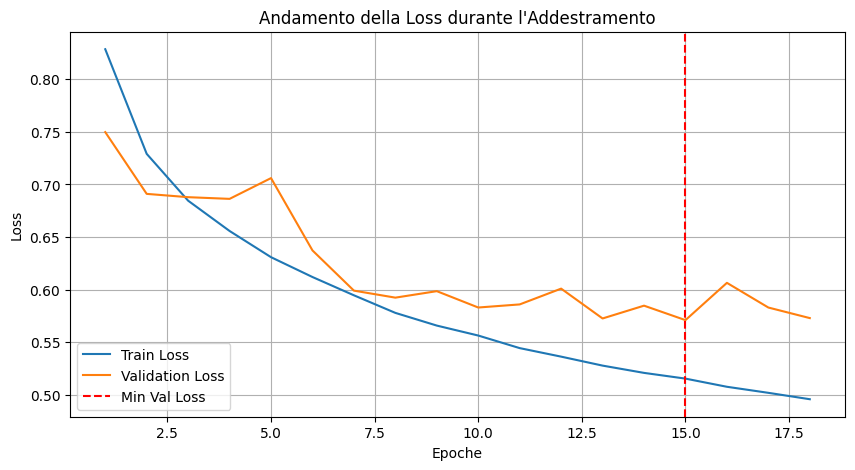

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

# Evidenzia la minima perdita di validazione
min_val_loss = min(val_losses)
min_val_epoch = val_losses.index(min_val_loss) + 1
plt.axvline(min_val_epoch, linestyle='--', color='r', label='Min Val Loss')

plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Andamento della Loss durante l\'Addestramento')
plt.legend()
plt.grid(True)
plt.show()


#Valutazione
**Inciso sulle Metriche di Valutazione (Definizione e Interpretazione)**

Sono state assunte le metriche comunemente utilizzate nella regressione:

Mean Absolute Error (MAE): Misura l'errore medio assoluto tra le predizioni del modello e i valori reali. Un MAE più basso indica una migliore accuratezza del modello. ​
Analytics Vidhya

Root Mean Squared Error (RMSE): È la radice quadrata dell'errore quadratico medio. Penalizza maggiormente gli errori più grandi rispetto al MAE, rendendolo sensibile agli outlier. ​

R-Squared (R²): Indica la proporzione della varianza nei dati dipendenti spiegata dal modello. Un R² vicino a 1 suggerisce che il modello spiega bene la variabilità dei dati; un valore vicino a 0 indica il contrario.


🔵 **GRAFICI DI EVOLUZIONE DELLE METRICHE**

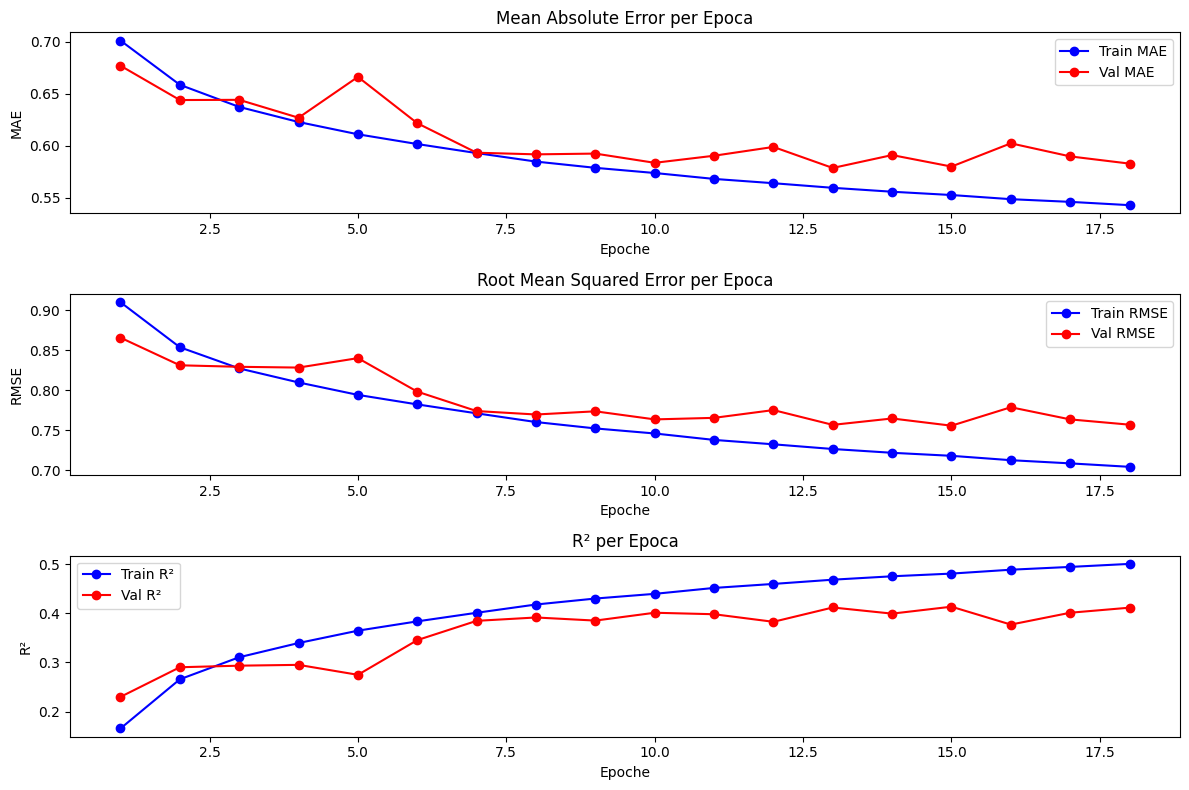

In [ ]:

import matplotlib.pyplot as plt

epochs = range(1, len(train_mae) + 1)

plt.figure(figsize=(12, 8))

# MAE
plt.subplot(3, 1, 1)
plt.plot(epochs, train_mae, 'bo-', label='Train MAE')
plt.plot(epochs, val_mae, 'ro-', label='Val MAE')
plt.xlabel('Epoche')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error per Epoca')

# RMSE
plt.subplot(3, 1, 2)
plt.plot(epochs, train_rmse, 'bo-', label='Train RMSE')
plt.plot(epochs, val_rmse, 'ro-', label='Val RMSE')
plt.xlabel('Epoche')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error per Epoca')

# R²
plt.subplot(3, 1, 3)
plt.plot(epochs, train_r2, 'bo-', label='Train R²')
plt.plot(epochs, val_r2, 'ro-', label='Val R²')
plt.xlabel('Epoche')
plt.ylabel('R²')
plt.legend()
plt.title('R² per Epoca')

plt.tight_layout()
plt.show()


🟢 **Interpretazione dei Grafici**

MAE e RMSE: Una diminuzione costante di queste metriche indica che il modello sta migliorando nell'accuratezza delle predizioni. Se le curve di validazione iniziano ad aumentare mentre quelle di training continuano a diminuire, potrebbe essere un segnale di overfitting.​

R²: Un aumento di R² suggerisce che il modello sta spiegando una maggiore proporzione della varianza nei dati. Valori stabili o in diminuzione possono indicare underfitting o overfitting, a seconda del contesto.​

🔵  **Valutazione del modello sul dataset di test**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        sequences, scores, lengths = batch
        sequences = sequences.to(device)
        scores = scores.to(device)

        outputs = model(sequences, lengths)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(scores.cpu().numpy())

# Calcolo delle metriche
rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"📊 Test RMSE: {rmse:.4f}")
print(f"📊 Test MAE:  {mae:.4f}")
print(f"📊 Test R²:   {r2:.4f}")


📊 Test RMSE: 0.7541
📊 Test MAE:  0.5804
📊 Test R²:   0.4236


🔵 **Plot predizioni vs target**

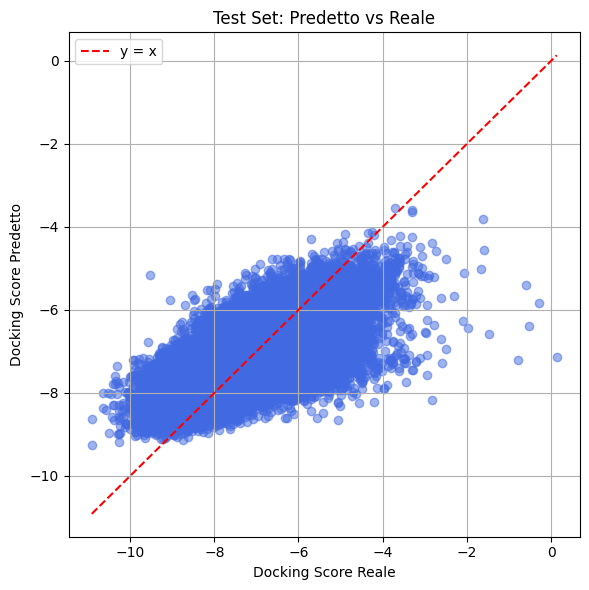

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.5, color='royalblue')
plt.plot([min(all_targets), max(all_targets)],
         [min(all_targets), max(all_targets)], 'r--', label='y = x')
plt.xlabel("Docking Score Reale")
plt.ylabel("Docking Score Predetto")
plt.title("Test Set: Predetto vs Reale")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔵 **Outliers**

In [ ]:
import numpy as np
import pandas as pd

# Calcolo degli errori assoluti
errors = np.abs(np.array(all_preds) - np.array(all_targets))

# Costruiamo un DataFrame per ispezione
outlier_df = pd.DataFrame({
    "predicted_score": all_preds,
    "true_score": all_targets,
    "abs_error": errors
})

# Ordina dal peggiore al migliore errore
outlier_df_sorted = outlier_df.sort_values(by="abs_error", ascending=False)

# Visualizza i primi 10 outlier
top_outliers = outlier_df_sorted.head(10)
top_outliers.reset_index(drop=True, inplace=True)
top_outliers


,predicted_score,true_score,abs_error
0,-7.128695,0.136049,7.264744
1,-7.215950,-0.794732,6.421218
2,-6.390221,-0.515391,5.874830
3,-5.829973,-0.284108,5.545865
4,-8.177591,-2.837610,5.339981
5,-6.568283,-1.462310,5.105973
6,-5.410877,-0.596545,4.814332
7,-7.269609,-2.588650,4.680959
8,-7.565017,-2.946220,4.618797
9,-6.439486,-1.968640,4.470846


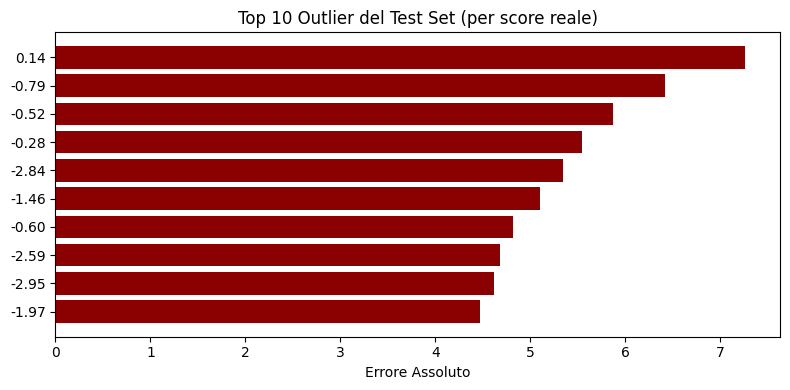

In [ ]:


plt.figure(figsize=(8,4))
plt.barh(range(10), top_outliers["abs_error"], color='darkred')
plt.yticks(range(10), [f"{s:.2f}" for s in top_outliers["true_score"]])
plt.xlabel("Errore Assoluto")
plt.title("Top 10 Outlier del Test Set (per score reale)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()